# Cookie Cats A/B Test: Retention Analysis

**Author:** Ante Mislav Vukojević
<br>

### 1. The Business Problem

This is an analysis of an A/B test conducted on the mobile game Cookie Cats. The game uses 'gates' that force players to wait a certain time before progressing. The objective is to determine if moving the first gate from level 30 to level 40 has a significant impact on player retention.

The core question: **Which gate placement drives better long-term player engagement?** We will analyze 1-day and 7-day retention as our key metrics.

### 2. Setup & Data Exploration

First step is always to load the data and get a feel for it. Need to check for missing values, data types, and the overall structure to make sure the foundation of the analysis is solid.

In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('cookie_cats.csv')

# Initial check
df.head()

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True


In [2]:
# Check for missing values and data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


**Initial Findings:**
* The dataset contains 90,189 records.
* There are no missing values, which is great.
* `retention_1` and `retention_7` are boolean types, which is perfect for calculating rates.

### 3. Comparing Retention Rates

Let's get the first look at the results. A simple `groupby` on the test versions will show the mean retention for each group. This gives us the raw performance numbers.

In [3]:
# Calculate mean retention for each version
retention_by_version = df.groupby('version')[['retention_1', 'retention_7']].mean()
retention_by_version

,retention_1,retention_7
version,,
gate_30,0.448188,0.190201
gate_40,0.442283,0.182000


**Analysis of Means:**

On the surface, the `gate_30` version appears to perform slightly better on both metrics.
* **1-Day Retention:** `gate_30` is higher by ~0.6%.
* **7-Day Retention:** `gate_30` is higher by ~0.8%.

The difference in 1-day retention is likely negligible from a user experience standpoint, as most players wouldn't have reached level 30 within their first day. The more telling metric should be 7-day retention, as more users would have hit the gate by then.

The key question is whether this small difference is a real effect or just random noise in the data. For that, we need to check for statistical significance.

### 4. Statistical Significance Testing

To test for significance, I'll use bootstrapping. It's a robust and intuitive method that relies on computational simulation rather than traditional statistical assumptions. The process simulates running the experiment thousands of times to see how often our observed result occurs, which gives us a p-value.

I'm using a vectorized NumPy implementation here because it's significantly faster than a standard Python `for` loop.

In [4]:
# Store the boolean retention data for each group in NumPy arrays for efficiency
retention_1_30 = df[df['version'] == 'gate_30']['retention_1'].values
retention_1_40 = df[df['version'] == 'gate_40']['retention_1'].values
retention_7_30 = df[df['version'] == 'gate_30']['retention_7'].values
retention_7_40 = df[df['version'] == 'gate_40']['retention_7'].values

# Set number of bootstrap iterations
iterations = 10000

# --- 1-Day Retention Simulation ---
boot_1d_30 = np.random.choice(retention_1_30, size=(iterations, len(retention_1_30)), replace=True)
boot_1d_40 = np.random.choice(retention_1_40, size=(iterations, len(retention_1_40)), replace=True)
boot_1d_diff = boot_1d_30.mean(axis=1) - boot_1d_40.mean(axis=1)

# --- 7-Day Retention Simulation ---
boot_7d_30 = np.random.choice(retention_7_30, size=(iterations, len(retention_7_30)), replace=True)
boot_7d_40 = np.random.choice(retention_7_40, size=(iterations, len(retention_7_40)), replace=True)
boot_7d_diff = boot_7d_30.mean(axis=1) - boot_7d_40.mean(axis=1)

# --- Calculate P-Values ---
# The p-value is the probability that the observed difference is zero or negative
p_value_1d = (boot_1d_diff <= 0).mean()
p_value_7d = (boot_7d_diff <= 0).mean()

print(f"P-value for 1-day retention: {p_value_1d:.4f}")
print(f"P-value for 7-day retention: {p_value_7d:.4f}")

P-value for 1-day retention: 0.0350
P-value for 7-day retention: 0.0008


**Significance Analysis:**

Using a standard significance level of α = 0.05:
* **1-Day Retention:** The p-value is significant (p < 0.05).
* **7-Day Retention:** The p-value is highly statistically significant (p < 0.01).

This confirms that the drop in retention for the `gate_40` group is a real effect and not just due to random chance. The effect is much stronger for the more important 7-day metric.

### 5. Visualization

A clustered bar chart is the best way to present these findings to stakeholders. It provides a clear, immediate visual comparison of the performance of the two groups across both metrics.

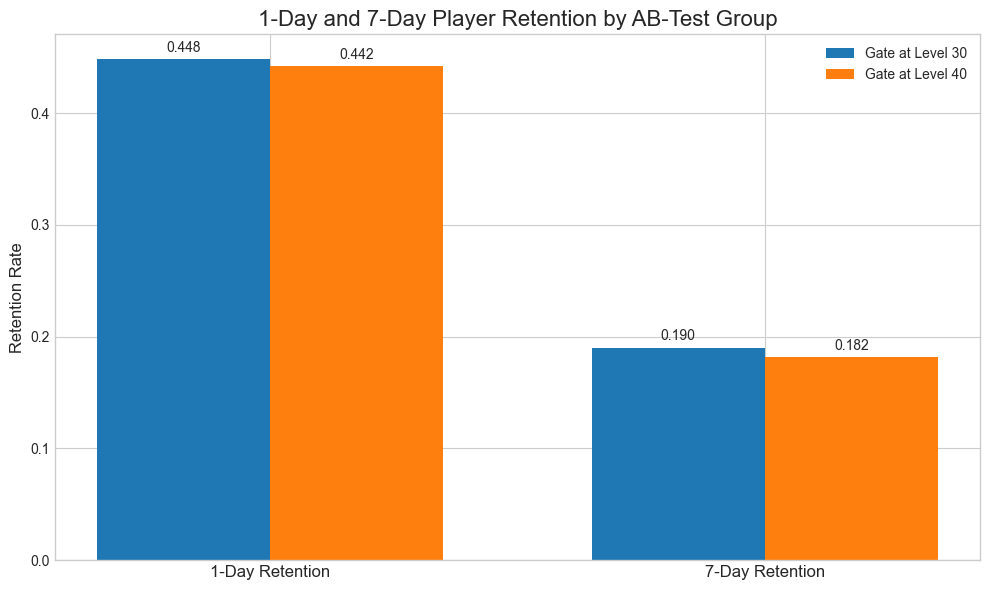

In [5]:
# --- Data Preparation for plotting ---
labels = ['1-Day Retention', '7-Day Retention']
gate_30_means = retention_by_version.loc['gate_30'].values
gate_40_means = retention_by_version.loc['gate_40'].values

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

# --- Chart Creation ---
plt.style.use('seaborn-v0_8-whitegrid')
fig, ax = plt.subplots(figsize=(10, 6))

rects1 = ax.bar(x - width/2, gate_30_means, width, label='Gate at Level 30')
rects2 = ax.bar(x + width/2, gate_40_means, width, label='Gate at Level 40')

# --- Professional Touches ---
ax.set_title('1-Day and 7-Day Player Retention by AB-Test Group', fontsize=16)
ax.set_ylabel('Retention Rate', fontsize=12)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontsize=12)
ax.legend()

ax.bar_label(rects1, padding=3, fmt='%.3f')
ax.bar_label(rects2, padding=3, fmt='%.3f')

fig.tight_layout()

# --- Save the chart to a file ---
plt.savefig('retention_chart.png', dpi=300)

plt.show()

### 6. Conclusion & Recommendation

The analysis is clear and the results are statistically significant.

Both 1-day and 7-day retention rates are negatively impacted by moving the gate from level 30 to level 40. The effect on 7-day retention is particularly strong, which is a critical metric for predicting the long-term health of the player base. A lower 7-day retention rate will almost certainly lead to lower overall player lifetime value.

**Recommendation:** The company should **not** roll out the change. The gate should be kept at level 30 to maximize long-term player engagement.